In [1]:
# the aim of this notebook is to illustrate the use of the Arc2kmTM tidal model, used py pyTMD
# and to provide a short, minimalistic example of how to use pyTMD to predict tide elevation
# note that if you want to use another of the models supported by pyTMD, you may need to do small changes to the code
# see in particular for help:
# (tide): https://github.com/tsutterley/pyTMD/blob/main/notebooks/Plot%20Tide%20Forecasts.ipynb
# (currents): https://github.com/tsutterley/pyTMD/blob/main/notebooks/Plot%20Antarctic%20Tidal%20Currents.ipynb
# see the Arc2kmTM_README_v1.pdf document, Arc2kmTM: Model Summary, for units

In [2]:
import datetime
import numpy as np
import matplotlib.pyplot as plt

import pyTMD.io
import pyTMD.time
import pyTMD.utilities
import pyTMD.predict

import pandas as pd

In [3]:
# my pyTMD version, installed from conda
pyTMD.__version__

'2.0.6'

In [4]:
# BELOW IS TO PREDICT TIDE ELEVATION

In [5]:
# parameters for the prediction

# location: lat and lon
# can be either a single value each, or 2 np arrays (lat1, lat2, ...) and (lon1, lon2, ...) so that (lat1, lon1), (lat2, lon2), ... are the positions of interest
# --
# Ny-Ålesund close
lat_to_predict = 79.029
lon_to_predict = 11.178
# --
# Ny-Ålesund far
# lat_to_predict = 79.056
# lon_to_predict = 9.183

# time: either a single datetime, or a np array of datetimes
start_day_to_predict = datetime.datetime(2023, 7, 1, 0, 0, 0, tzinfo=datetime.timezone.utc)
number_of_hours_to_predict = 24*31
times_to_predict = [start_day_to_predict + datetime.timedelta(hours=hr) for hr in range(number_of_hours_to_predict)]

# details about the model location and format on my disk
model_path = "/home/jrmet/Desktop/Data/tides/resource_map_doi_10_18739_A2D21RK6K/"  # obtained from https://arcticdata.io/catalog/view/doi:10.18739/A2D21RK6K
model_name = "Arc2kmTM"
model_is_compressed = False
model_atlas = "netcdf"

In [6]:
# illustrate how the input model files look like
# this is simply the un-zipping of the arcticdata model data

%ls $model_path
print("---")
%ls $model_path/$model_name

Arc2kmTM/     bagit.txt         metadata/
bag-info.txt  manifest-md5.txt  tagmanifest-md5.txt
---
Arc2kmTM_FileFormat.pdf  h_Arc2kmTM_v1         UV_Arc2kmTM_v1
Arc2kmTM_README_v1.pdf   Model_Arc2kmTM_v1     xy_ll_Arc2kmTM.m
grid_Arc2kmTM_v1         Revision_history.txt


In [7]:
# note that pytmd internally uses its own time system with a given epoch start - dont mess it up and make sure to convert to it :)
pytmd_times_to_predict = [pyTMD.time.convert_calendar_dates(crrt_time.year, crrt_time.month, crrt_time.day, crrt_time.hour, crrt_time.minute, crrt_time.second) for crrt_time in times_to_predict]
model_time_delta = np.zeros_like(pytmd_times_to_predict)

In [8]:
# extract the mode data and prepare the tooling for tide computation at the location of interest
# needs to be run just once at a given location to extract the tidal components and phases
# if using another model, some changes may be necessary; see: https://github.com/tsutterley/pyTMD/blob/main/notebooks/Plot%20Tide%20Forecasts.ipynb

tide_model_base = pyTMD.io.model(
    model_path,
    format=model_atlas,
    compressed=model_is_compressed,
)

tide_model = tide_model_base.elevation(model_name)
# tide_model.type is type 'z', i.e. just tide elevation and a single output

tide_constituents = pyTMD.io.OTIS.read_constants(
    tide_model.grid_file,
    tide_model.model_file,
    tide_model.projection,
    type=tide_model.type,
    grid=tide_model.format
)

list_time_constituents = tide_constituents.fields
print(f"tidal constituents used in the present model are: {list_time_constituents = }")

tide_amplitude, tide_phase, model_bathymetry = pyTMD.io.OTIS.interpolate_constants(
    np.atleast_1d(lon_to_predict),
    np.atleast_1d(lat_to_predict),
    tide_constituents,
    tide_model.projection,
    type=tide_model.type,
    method='spline',
    extrapolate=True
)

tide_complex_phase = -1j * tide_phase * np.pi / 180.0
tide_constituent_oscillation = tide_amplitude * np.exp(tide_complex_phase)

tidal constituents used in the present model are: list_time_constituents = ['m2', 's2', 'k1', 'o1', 'n2', 'p1', 'k2', 'q1']


In [9]:
tide_complex_phase

masked_array(data=[[-0.06247963011264801j, -0.8489143252372742j,
                    -4.426159326230184j, -1.9878078699111938j,
                    -5.8797287980662745j, -4.337969724331991j,
                    -0.9130497574806213j, -0.13438604772090912j]],
             mask=[[False, False, False, False, False, False, False,
                    False]],
       fill_value=1e+20)

In [10]:
tide_constituent_oscillation

masked_array(data=[[(0.4193906777417112-0.02623752448442905j),
                    (0.11027994327238795-0.1252607341628475j),
                    (-0.021702359288938156+0.07373947356111339j),
                    (-0.009038692517654344-0.02040369718874693j),
                    (0.09739921697848977+0.041577151688825885j),
                    (-0.009088566077462234+0.0231287115947422j),
                    (0.03052787815040282-0.03951826579226765j),
                    (0.015726358087985122-0.0021262181018126764j)]],
             mask=[[False, False, False, False, False, False, False,
                    False]],
       fill_value=1e+20)

In [11]:
# actually perform the prediction
# as long as the location is not changed, this can be used many times to predict for different times

# this is to predict a time series at a single location over many times; for more alternatives, for example predict a map at a single times for many locations, see map in
# https://github.com/tsutterley/pyTMD/blob/main/pyTMD/predict.py
tide_meters = pyTMD.predict.time_series(
    np.atleast_1d(pytmd_times_to_predict),
    tide_constituent_oscillation,
    list_time_constituents,
    deltat=model_time_delta,
    corrections=tide_model.format
)

minor_constituents = pyTMD.predict.infer_minor(
    np.atleast_1d(pytmd_times_to_predict),
    tide_constituent_oscillation,
    list_time_constituents,
    deltat=model_time_delta,
    corrections=tide_model.format)

tide_meters.data[:] += minor_constituents.data[:]

In [12]:
# the predicted tides, in meters, is just a numpy masked array

tide_meters

masked_array(data=[0.2406398705548227, 0.08826629940393739,
                   -0.07795319872284782, -0.2126689208886907,
                   -0.2787148849660027, -0.256772788163883,
                   -0.15061935784936764, 0.013441425104574078,
                   0.19291182185961755, 0.33969109216654775,
                   0.41231297240858183, 0.3867581597566102,
                   0.2630771136085127, 0.06606864719546335,
                   -0.16027011276605818, -0.36324040023082965,
                   -0.494334239046328, -0.5213252827477448,
                   -0.4365101330814285, -0.25897211682527277,
                   -0.03021007334238477, 0.19586664304478923,
                   0.366144786250789, 0.44144430411703506,
                   0.40628849967210595, 0.27281458841269546,
                   0.07777653205025441, -0.12667925764885954,
                   -0.28620475716689114, -0.35811689483269915,
                   -0.32243687752959155, -0.1872698954863637,
                   0

In [13]:
# put in pandas for more flexible plotting later on
df_pytmd = pd.DataFrame({'utc_timestamp':times_to_predict, 'pytmd_tide_m':tide_meters})

In [14]:
# for cross validation, compare to the observation + harmonic modeling from Ny-Ålesund, available at https://www.kartverket.no/til-sjos/se-havniva/resultat?id=587933&location=Ny-%C3%85lesund

In [15]:
# read; note that I added a line "timestamp observation astronomical_tide" under the line 15 (i.e. new line 16) to have easy parsing with pandas
df_kartverket = pd.read_csv("./data_Kartverket_NyAlesund_Juni_2023.txt", skiprows=15, delimiter=r"\s+")  # parse ignoring file header and considering several spaces in a row as a single space
df_kartverket["utc_timestamp"] = pd.to_datetime(df_kartverket["timestamp"], utc=True)  # actually get UTC timestamps out of the ISO datetime strings
df_kartverket["kartverket_astronomical_tide_m"] = df_kartverket["astronomical_tide"] / 100.0  # cm (Kartverket) to m
df_kartverket["kartverket_observation_m"] = df_kartverket["observation"] / 100.0  # cm (Kartverket) to m

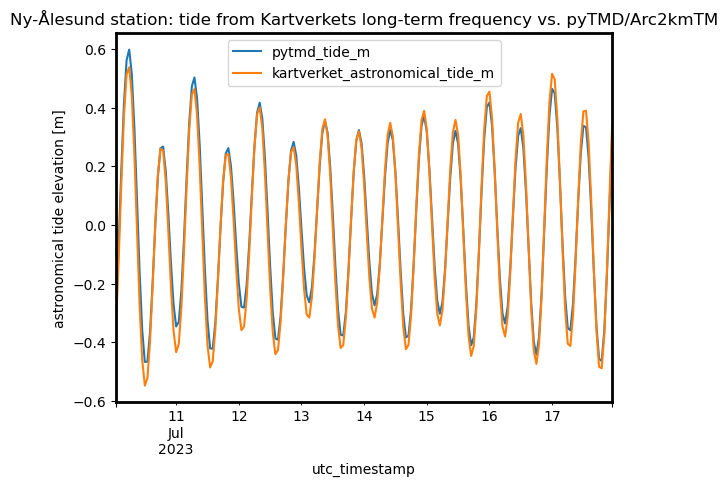

In [16]:
# compare the model data generated by pyTMD to Kartverket astronomical tide computed over a long time series

# time window to plot for comparison
utc_timestamp_start = datetime.datetime(2023, 7, 10, 0, 0, 0, tzinfo=datetime.timezone.utc)
utc_timestamp_stop = datetime.datetime(2023, 7, 18, 0, 0, 0, tzinfo=datetime.timezone.utc)

def get_mask(df_in, utc_timestamp_start, utc_timestamp_stop):
    mask = (df_in["utc_timestamp"] > utc_timestamp_start) & (df_in["utc_timestamp"] < utc_timestamp_stop) 
    return mask

# plotting
fig = plt.figure()
ax = plt.gca()

mask_pytmd = get_mask(df_pytmd, utc_timestamp_start, utc_timestamp_stop)
df_pytmd.loc[mask_pytmd].plot(x="utc_timestamp", y="pytmd_tide_m", ax=ax)

mask_kartverket = get_mask(df_kartverket, utc_timestamp_start, utc_timestamp_stop)
# df_kartverket.loc[mask_kartverket].plot(x="utc_timestamp", y=["observation_m", "kartverket_astronomical_tide_m"], ax=ax)
df_kartverket.loc[mask_kartverket].plot(x="utc_timestamp", y=["kartverket_astronomical_tide_m"], ax=ax)

plt.ylabel("astronomical tide elevation [m]")
plt.title("Ny-Ålesund station: tide from Kartverkets long-term frequency vs. pyTMD/Arc2kmTM")

plt.show()

In [17]:
# success, the comparison is very good - this is a global model for the whole Arctic!